In [1]:
import sys
sys.path.append("../../smsl")

In [205]:
from smsl.makeDataframe import SpringAgent
from smsl.config import ConfAgent
from smsl.graph import RB
from smsl.plotAgent import PlotAgent, palette, SinglePlotAgent
from smsl.plotAgent import font_label, font_xylabel, font_xyticks

In [183]:
import os
import pandas as pd
import numpy as np
from IPython.display import JSON
import json
import matplotlib.pyplot as plt
from copy import deepcopy

In [184]:
class HotSpotAgent(dict, ConfAgent):
    def __init__(self, MAgent):
        ConfAgent.__init__(self)
        self.end_ns = self.time_num
        self.framesperns = self.frame_num // self.time_num
        self.MAgent = MAgent
    def load_systems(self, system2offical_name):
        ori_path = os.getcwd()
        for system, system_offical_name in system2offical_name.items():
            os.chdir(f'../../{system}/d.fluctmatch')
            b_agent = SpringAgent()
            b_agent.system_offical_name = system_offical_name
            self[system] = b_agent
        os.chdir(ori_path)
    def read_dict_hotspot_from_json(self, subgroups, is_return=False):
        dict_hotspot = {}
        for s in subgroups:
            with open(f'./data/{s}.json', 'r') as f:
                data = json.load(f)
                dict_hotspot[s] = {system:d1 for system, d1 in data.items() if system in self.keys()} 
            for system, d1 in dict_hotspot[s].items():
                positions = list(d1.keys())
                for position in positions:
                    position_tuple = tuple(position.split(','))
                    if len(position_tuple)==1:
                        position_tuple = position_tuple[0]
                    d1[position_tuple] = d1.pop(position)
            ## for dsdna
            if 'dsdna' in self:
                with open(f'./data/dsdna.json', 'r') as f:
                    data = json.load(f)
                    dict_hotspot[s]['dsdna'] = data[s]['dsdna']
        if is_return:
            return dict_hotspot
        else:
            self.dict_hotspot = dict_hotspot

In [186]:
system2offical_name = {
'propeller': 'Propeller',
'basket'   : 'Basket',
'chair'    : 'Chair',
'hybrid-i' : 'Hybrid-I',
'hybrid-ii': 'Hybrid-II',
'dsdna'    : 'dsDNA',
# 'basket_na': 'Basket-Na',
# 'hybrid-ii_wttel26'    : 'Hybrid-II-wtTel26',
# 'propeller_poh'        : 'Propeller-POH',
# 'propeller_ewv'        : 'Propeller-EWV', 
# 'hybrid-ii_wttel26_ewv': 'Hybrid-II-wtTel26-EWV', 
# 'hybrid-ii_wttel26_poh': 'Hybrid-II-wtTel26-POH', 
}

subgroups = ['rb']

In [187]:
hs_agent = HotSpotAgent(RB)
hs_agent.load_systems(system2offical_name)
hs_agent.read_dict_hotspot_from_json(subgroups)

In [188]:
JSON(hs_agent.dict_hotspot)

<IPython.core.display.JSON object>

In [228]:
group2ks = {'T': [], 'A':[], 'G(anti)':[], 'G(syn)':[]}
natype2pairtype2basetype2ks = {
    'G-quadruplex': { 'Base': deepcopy(group2ks), 'GBA': deepcopy(group2ks) },
    'dsDNA'       : { 'Base': deepcopy(group2ks), 'GBA': deepcopy(group2ks) },
}
for system, dict_d1 in hs_agent.dict_hotspot[subgroups[0]].items():
    for position, dict_d2 in dict_d1.items():
        resn  = position[0]
        resid = int(position[1:])
        GBA   = hs_agent[system].GBAc[resid]
        basetype = f'{resn}({GBA})' if resn=='G' else resn
        natype = 'dsDNA' if system=='dsdna' else 'G-quadruplex'
        for hotspot_id, dict_d3 in dict_d2['hotspot'].items():
            if hotspot_id == 'avg':
                continue
            if hotspot_id in ['1', '2', '3']:
                k = dict_d3['k']['avg']
                # key = (system, position, dict_d3['query'])
                natype2pairtype2basetype2ks[natype]['Base'][basetype].append(k)
            elif hotspot_id in ['4', '5']:
                k = dict_d3['k']['avg']
                # key = (system, position, dict_d3['query'])
                natype2pairtype2basetype2ks[natype]['GBA'][basetype].append(k)

In [379]:
JSON(natype2pairtype2basetype2ks)

<IPython.core.display.JSON object>

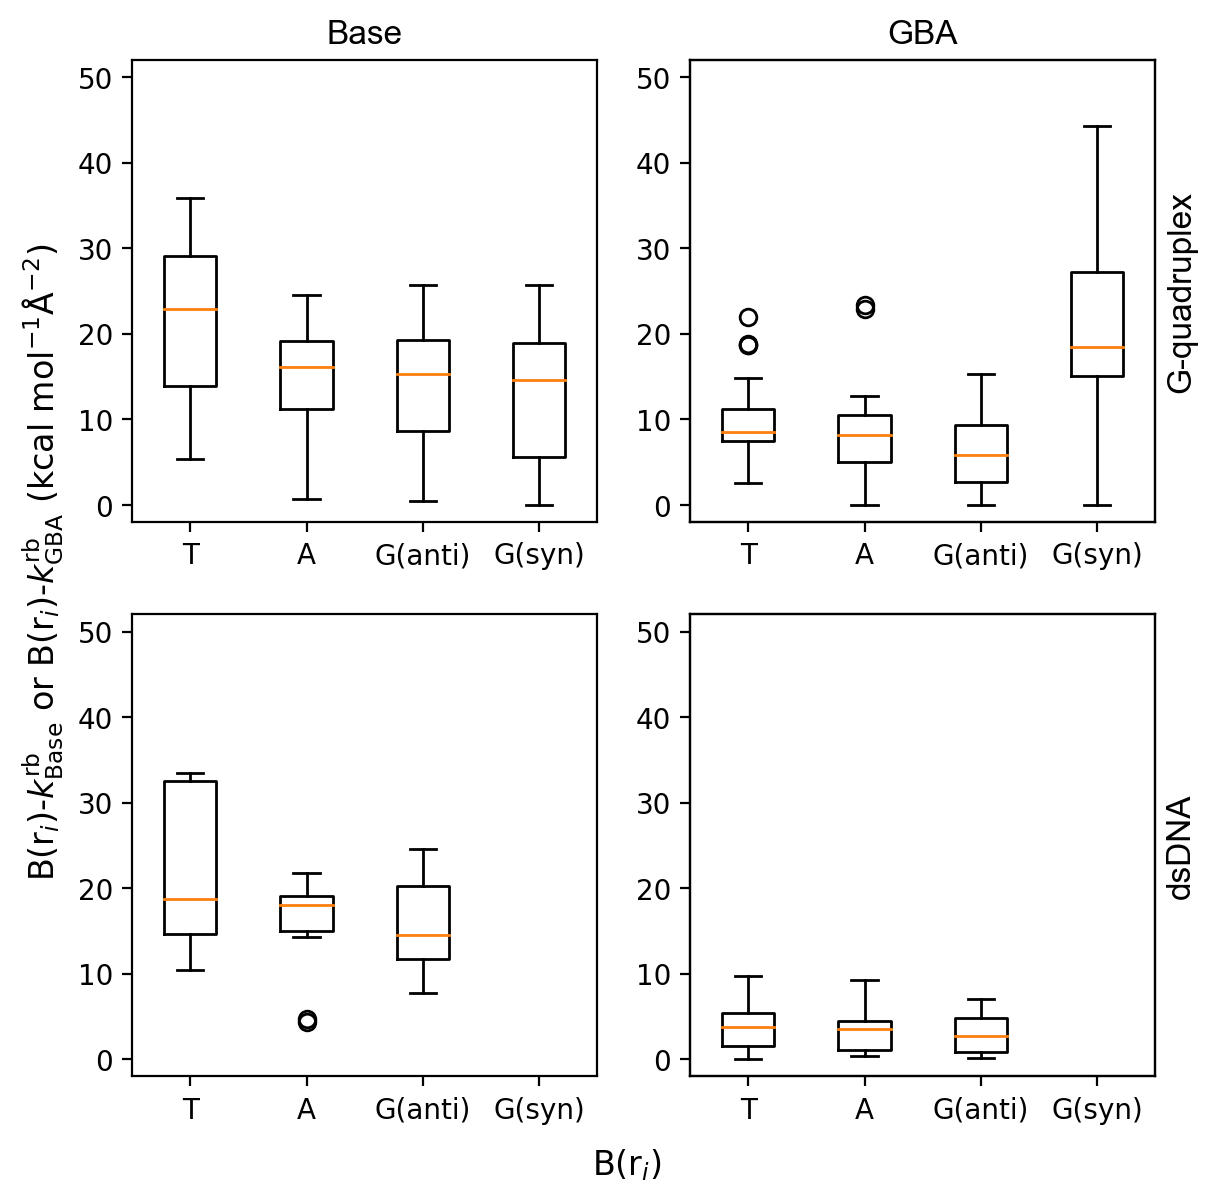

In [386]:
p_agent = PlotAgent(nrows=2, ncols=2, figsize_1=[3.3, 3.3], hspace=0.2, wspace=0.2, sharex=False, sharey=False)
for i, (natype, pairtype2basetype2ks) in enumerate(natype2pairtype2basetype2ks.items()):
    for j, (pairtype, basetype2ks) in enumerate(pairtype2basetype2ks.items()):
        p_agent.axs[i,j].boxplot(basetype2ks.values(), labels=basetype2ks.keys())
        p_agent.axs[i,j].set_ylim(-2, 52)
p_agent.axs[0,0].set_title('Base', fontdict=font_xylabel)
p_agent.axs[0,1].set_title('GBA' , fontdict=font_xylabel)
## G4DNA label
ax2 = p_agent.axs[0,1].twinx()
ax2.set_ylabel('G-quadruplex', fontdict=font_xylabel)
ax2.set_yticks([])
## DsDNA label
ax2 = p_agent.axs[1,1].twinx()
ax2.set_ylabel('dsDNA', fontdict=font_xylabel)
ax2.set_yticks([])
p_agent.fig.supxlabel(r'B(r$_{i}$)', y=0.03)
p_agent.fig.supylabel(r'B(r$_{i}$)-$k^{\rm{rb}}_{\rm{Base}}$ or B(r$_{i}$)-$k^{\rm{rb}}_{\rm{GBA}}$ (kcal mol$^{-1} {\rm{\AA}^{-2}}$)', x=0.04)
p_agent.savefig('krb_by_aiaj.svg')